<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/choixSejourLogiqueFloueSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séjours dans le flou avec skfuzzy

L'objectif est de pouvoir représenter des règles de type :
- SI le beau temps est prévu ALORS j’achète l’offre de location pour une longue durée
- SI le beau temps est prévu et que le loyer est cher ALORS j’achète l’offre de location pour une moyenne durée
- SI le temps est de moyen à beau, ET que la location reste abordable, ALORS j’achète l’offre pour une moyenne durée
- SI le temps prévu est mauvais, MAIS que la location est très abordable, ALORS j’achète l’offre pour une courte durée
- le reste du temps, SI la location est chère ET qu’il ne fait pas beau, ALORS je n’y vais pas ; de même SI la location est dans des prix abordable MAIS qu’il fait mauvais

Une partie du code est absent, référez-vous  l'exemple sur la logique floue et le freinage pour compléter ce code...

On utilise pour cela la librairie python skfuzzy
*(si elle n'est pas présente, installez là avec cette ligne : !pip install -U scikit-fuzzy)*

In [ ]:
 !pip install -U scikit-fuzzy

In [1]:
#les imports
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl 
import matplotlib.pyplot as plt

## les antécédents et les conséquents
- Les antécédents sont les variables utilisées pour prendre les décisions (ici la météo, le coût)
- les conséquents sont les déductions (ici la durée de séjour)

In [22]:
#### Antecedent et Consequent
# la meteo est située dans un intervale de 0 à 40 coupé par pas de 1 
meteo = ctrl.Antecedent(np.arange(0,40,1), 'meteo')
# l'offre de séjour est située dans un intervale de 0 à 200 la nuit, coupé par pas de 5
offre = ctrl.Antecedent(np.arange(0,200,5), 'cout')
# la durée de séjour est située dans un intervale de 0 à 5 coupé par pas de 0.5 
duree = ctrl.Consequent(np.arange(0,5,0.5), 'duree')

In [23]:
meteo


Antecedent: meteo

### intervales
on définit ensuite les intervales utilisés dans les antécédents et les conséquents.
#### La météo
- le temps est beau à partir de 22°, moyen à partir de 15°, frais en dessous


In [24]:
#une courbe sigmoide, meteo moche aux températures froides, et est à moitié moche à 8°
meteo_moche = fuzz.sigmf(meteo.universe, 8, -0.8)
#une courbe en cloche, météo commmence à être ressentie légèrement moyenne à 12°, parfaitement moyenne à 15° pour décroitre et ne l'être plus à 18°
meteo_moyenne = fuzz.gbellmf(meteo.universe, 12, 1.5, 15) #on dessine la moitié de la cloche, l'autre sera son miroir
#une courbe sigmoide, meteo belle aux températures chaude, et est à moitié belle à 20°
meteo_belle = fuzz.sigmf(meteo.universe, 20, 0.8)
meteo['moche'] = meteo_moche
meteo['moyenne'] = meteo_moyenne
meteo['belle'] = meteo_belle

In [25]:
meteo.terms.values()

odict_values([meteo[moche], meteo[moyenne], meteo[belle]])

On peut vérifier les courbes d'appartenance : 
- *ici les courbes sont trapézoidales, mais vous pouvez les définir autrement*

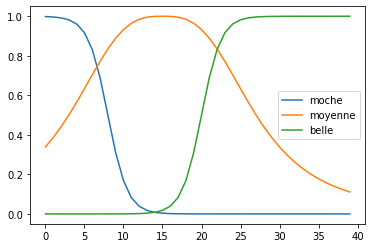

In [26]:
plt.plot(meteo.universe, meteo_moche,  label='moche')
plt.plot(meteo.universe, meteo_moyenne,label='moyenne')
plt.plot(meteo.universe, meteo_belle,  label='belle')
plt.legend()
plt.show()


#### Le coût
- une offre sous 30€ la nuit est très abordable, elle reste abordable jusque 70€, elle est ressentie comme chère ensuite

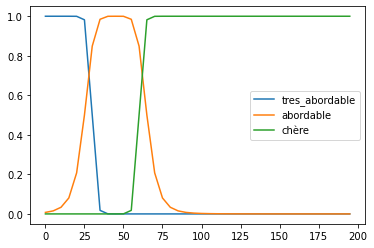

In [27]:

#une courbe sigmoide,  cout considéré faible aux petits prix, et est à moitié faible à 30€
cout_faible = fuzz.sigmf(offre.universe, 30, -0.8)
#une courbe en cloche, cout commmence à être ressenti légèrement moyen à 20€, parfaitement moyenne à 45 pour décroitre et ne l'être plus à 65€
cout_moyen = fuzz.gbellmf(offre.universe, 20, 3, 45)
#une courbe sigmoide, cout élevé belle aux tarifs hauts,et est à moitié élevé à 60°
cout_eleve = fuzz.sigmf(offre.universe, 60, 0.8)

offre['tres_abordable'] = cout_faible
offre['abordable'] = cout_moyen
offre['chere'] = cout_eleve
#juste pour voir les courbes
plt.plot(offre.universe, cout_faible, label='tres_abordable')
plt.plot(offre.universe, cout_moyen,  label='abordable')
plt.plot(offre.universe, cout_eleve,  label='chère')
plt.legend()
plt.show()

In [28]:
cout_moyen

array([7.64839778e-03, 1.53846154e-02, 3.36440922e-02, 8.07061791e-02,
       2.07697378e-01, 5.00000000e-01, 8.48911917e-01, 9.84615385e-01,
       9.99755919e-01, 1.00000000e+00, 9.99755919e-01, 9.84615385e-01,
       8.48911917e-01, 5.00000000e-01, 2.07697378e-01, 8.07061791e-02,
       3.36440922e-02, 1.53846154e-02, 7.64839778e-03, 4.07929122e-03,
       2.30675181e-03, 1.36986301e-03, 8.47874260e-04, 5.43695259e-04,
       3.59464703e-04, 2.44081035e-04, 1.69665183e-04, 1.20412790e-04,
       8.70563656e-05, 6.39959043e-05, 4.77555047e-05, 3.61250265e-05,
       2.76682006e-05, 2.14330111e-05, 1.67769345e-05, 1.32591017e-05,
       1.05723802e-05, 8.49978751e-06, 6.88603094e-06, 5.61862412e-06])

#### La durée
- une durée de séjour est considérée longue à partir de 3j
- une durée est moyenne entre 2j et 3j
- une courte durée tient de 1j à 2j
- ne pas partir revient à une durée de 0j à 1j



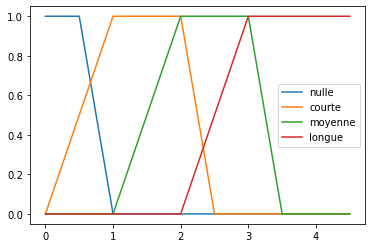

In [29]:

duree_nulle = fuzz.trapmf(duree.universe, [0,0,0.5,1])
duree_courte = fuzz.trapmf(duree.universe, [0,1,2,2.5])
duree_moyenne = fuzz.trapmf(duree.universe, [1,2,3,3.5])
duree_longue = fuzz.trapmf(duree.universe, [2,3,5,5])
duree['nulle'] = duree_nulle
duree['courte'] = duree_courte
duree['moyenne'] = duree_moyenne
duree['longue'] = duree_longue
#juste pour voir les courbes
plt.plot(duree.universe, duree_nulle,  label='nulle')
plt.plot(duree.universe, duree_courte, label='courte')
plt.plot(duree.universe, duree_moyenne,label='moyenne')
plt.plot(duree.universe, duree_longue, label='longue')
plt.legend()
plt.show()

## Définition des règles floues
Rappel, on souhaite définir : 
- si le beau temps est prévu alors j’achète l’offre de location pour une longue durée
- si le temps est de moyen, et que la location reste abordable, alors j’achète l’offre pour une moyenne durée
- si le temps prévu est mauvais, mais que la location est très abordable, alors j’achète l’offre pour une courte durée
- le reste du temps, si la location est chère et qu’il ne fait pas beau, je n’y vais pas ; de même si la location est dans des prix abordable mais qu’il fait mauvais



In [30]:
print(meteo.terms.values())

odict_values([meteo[moche], meteo[moyenne], meteo[belle]])


In [31]:
print(offre.terms.values())

odict_values([cout[tres_abordable], cout[abordable], cout[chere]])


In [32]:
print(duree.terms.values())

odict_values([duree[nulle], duree[courte], duree[moyenne], duree[longue]])


In [35]:

#on écrit
rule1  =  ctrl.Rule( meteo['belle'],                              duree['longue'])
rule2a =  ctrl.Rule( meteo['moyenne'] &  offre['tres_abordable'], duree['moyenne'])
rule2b =  ctrl.Rule( meteo['moyenne'] &  offre['abordable'],      duree['moyenne'])
rule3  =  ctrl.Rule( meteo['moche'] &    offre['tres_abordable'], duree['courte'])
rule4a =  ctrl.Rule( meteo['moche'] &    offre['chere'],          duree['nulle'])
rule4b =  ctrl.Rule( meteo['moyenne'] &  offre['chere'],          duree['nulle'])
rule5  =  ctrl.Rule( meteo['moche'] &    offre['abordable'],      duree['nulle'])
  

#on compile les règles
sejour_regles = ctrl.ControlSystem([rule1, rule2a, rule2b, rule3, rule4a, rule4b, rule5 ])
sejour_decision = ctrl.ControlSystemSimulation(sejour_regles)

In [36]:
sejour_decision.input

meteo : None
cout : None

## Observations
Testons le système : 
- une offre à 70€ est repérée et la météo annonce 17°, quelle est la décision à prendre ?

In [38]:
sejour_decision.input['meteo'] = 20
sejour_decision.input['cout'] = 65

sejour_decision.compute()

print(sejour_decision.output['duree'])

2.1149733343012254


la durée est <0.5, ce qui correspond à une durée nulle.

Vérifions en image :

/Users/emmanueladam/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


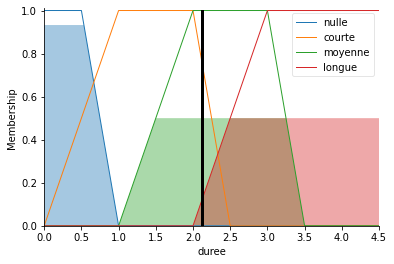

In [39]:
duree.view(sim=sejour_decision)

Que se passe-t-il lorsqu'une offre est trouvée à 80€ mais que la météo annonce 30° ?


In [41]:
sejour_decision.input['meteo'] = 30
sejour_decision.input['cout'] = 100

sejour_decision.compute()

print(sejour_decision.output['duree'])

3.0719666031635455


une durée de séjour longue est recomandée. vérification en image :

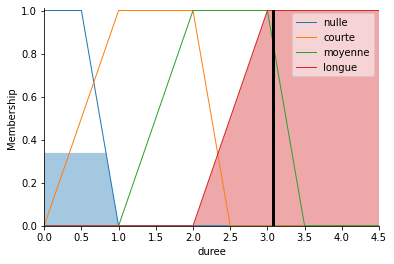

In [42]:
duree.view(sim=sejour_decision)

#### Impact des courbes
- Changez les courbes pour étudier l'impact sur le résultat